In [322]:
import numpy as np
import copy
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.ops import cascaded_union
from shapely.geometry import Point
import random
from shapely import affinity
import matplotlib.pyplot as plt
import time

In [ ]:
# Problems data structures

class Room():
    def __init__(self, shape):
        self.shape = shape
        self.polygon = Polygon(np.array(shape, dtype=np.float64))

class FurnitureItem():
    def __init__(self, unitcost, shape):
        self.shape = shape
        self.unit_cost = unitcost
        self.polygon = Polygon(np.array(shape, dtype=np.float64))
        self.total_cost = np.float64((np.float64(self.unit_cost) * self.polygon.area))
        self.sorting = (self.polygon, self.polygon.area)

class Problem():
    def __init__(self, room, furniture):
        self.room = room
        self.furniture = furniture

In [ ]:
# Parsing from problems files input

problems = []
with open('problems.rfp') as f:
    for line in f:
        furnitureList = []
        problem = line.replace(" ","").split("#")

        room_shape = problem[0].split(":")[1]
        furniture = problem[1].split(";")

        room = Room([tuple(np.float64(i) for i in el.strip('()').split(',')) for el in room_shape.split('),(')])

        for furnitureItem in furniture:
            parse_furniture = furnitureItem.strip().split(":")
            unit_cost = parse_furniture[0]
            shape = [tuple(np.float64(i) for i in el.strip('()').split(',')) for el in parse_furniture[1].split('),(')]
            furnitureItem = FurnitureItem(unit_cost, shape)
            furnitureList.append(furnitureItem)
        problems.append(Problem(room,furnitureList))

In [ ]:
def random_points_within(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            points.append(random_point)
    return points

In [ ]:
def get_output(solution):
    output = ""
    for x in solution:
        output = output + str(x[:-1]).replace('[','').replace(']','') + "; "
    return output

### Room 11

In [ ]:
# Set up specific shapes for map 11

base_room_11 = problems[10].room.polygon
f_items_11_vertices_13 = []

for item in problems[10].furniture:
    x,y = item.polygon.exterior.xy
    if(len(x)==13):
        f_items_11_vertices_13.append(item.polygon)
        
shape1 = Polygon([(-15.08889668642394, 3.9482917599290186), (-15.486653963472579, 4.34108833394011), (-15.409086789277868, 4.578750559561785), (-14.85619516383981, 4.661278436794042), (-15.253952440888451, 5.054075010805132), (-15.176385266693742, 5.291737236426808), (-14.623493641255685, 5.374265113659066), (-15.021250918304325, 5.7670616876701555), (-14.943683744109617, 6.00472391329183), (-14.390792118671559, 6.087251790524089), (-15.263873846963548, 6.635182712924596), (-16.039545588910634, 4.258560456707853)
])
shape2 = Polygon([(-5.6189199596134385, 1.558120177475971), (-5.782104649062396, 2.092789006873615), (-5.60087405519313, 2.2649966485327266), (-5.07522817800564, 2.074743102453306), (-5.238412867454597, 2.609411931850952), (-5.057182273585332, 2.781619573510064), (-4.531536396397843, 2.591366027430643), (-4.6947210858468, 3.1260348568282867), (-4.513490491977533, 3.2982424984873995), (-3.9878446147900437, 3.1079889524079785), (-4.495444587557226, 4.0051189695441565), (-6.307750526249887, 2.2830425529530354)
])
shape3 = Polygon([(6.5503158452884236e-15, -5.773159728050814e-15), (-1.069337658795283, -0.32636937889791806), (-1.413752942113506, 0.0360918088406148), (-1.0332458499546617, 1.0873835632155942), (-2.1025835087499516, 0.7610141843176814), (-2.4469987920681744, 1.1234753720562152), (-2.0664916999093297, 2.1747671264311945), (-3.13582935870462, 1.8483977475332818), (-3.480244642022843, 2.2108589352718147), (-3.099737549863999, 3.262150689646795), (-4.893997584136356, 2.2469507441124357), (-1.4498447509541268, -1.3776611332728972)])

multipolygon = base_room_11.difference(shape1).difference(shape2).difference(shape3)
modified_room_11 = multipolygon[0]

In [ ]:
# Algorithm Room 11

# Plotting room
roomX,roomY = problems[10].room.polygon.exterior.xy
plt.plot(roomX, roomY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

solution = []
shapes = copy.copy(problems[10].furniture)
initial_area = room_11.area
updatable_room = modified_room_11
while (updatable_room.area) > initial_area*0.7:
    while(updatable_room.area > 76):
        for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4:
                points = random_points_within(updatable_room,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if updatable_room.contains(polygon):
                    updatable_room = updatable_room.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (updatable_room.area))
                    
                    plt.plot(x, y, color='#e50000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)

    for j in shapes:
            x,y = j.polygon.exterior.xy
            if len(x) == 4 or len(x)==5:
                points = random_points_within(updatable_room,1)[0]
                polygon = affinity.translate(j.polygon, points.x, points.y)
                polygon = affinity.rotate(polygon, random.uniform(0,180),origin="centroid")
                if updatable_room.contains(polygon):
                    updatable_room = updatable_room.difference(polygon)
                    x,y = polygon.exterior.xy
                    solution.append(list(zip(*(x,y))))
                    shapes.remove(j)
                    print(len(shapes), (updatable_room.area))
                    
                    plt.plot(x, y, color='#e50000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                    display.display(plt.gcf())
                    display.clear_output(wait=True)


updatable_room.area

In [ ]:
print(get_output(solution))

In [ ]:
%matplotlib inline
import pandas as pd
from IPython import display

roomX,roomY = problems[10].room.polygon.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
z= 0
item = furniture_items_13[3]
print(z)
itemExX,itmeExY = item.exterior.xy
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[11]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
for i in range(250,300):
    rotated_trans_shape = affinity.rotate(trans_shape, i, origin=(x, y))
    sX,sY = rotated_trans_shape.exterior.xy  
    plt.plot(roomX, roomY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.plot(sX, sY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    display.display(plt.gcf())
    display.display(plt.clf())
    display.clear_output(wait=True)
    time.sleep(0.0001)                

In [ ]:
item = furniture_items_13[3]
itemExX,itmeExY = item.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[11]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
rotated_trans_shape = affinity.rotate(trans_shape, 259.5604053764044, origin=(x, y))
a,b = rotated_trans_shape.exterior.xy
print(rotated_trans_shape.difference(room_11).area)
coords = list(zip(*(a,b)))
str(coords)

In [ ]:
from scipy.optimize import fmin 
from scipy import optimize

def f(angle):
    return affinity.rotate(new_translated_shape, angle, origin=(room_vertice_x, room_vertice_y)).difference(updatable_room).area

In [394]:
# Algorithm Room 1

# Plotting room
roomX,roomY = problems[0].room.polygon.exterior.xy
#plt.plot(roomX, roomY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

solution = []
room_0 = problems[0].room.polygon
shapes = copy.copy(problems[0].furniture)
initial_area = room_0.area
updatable_room = room_0
tolerance = 10

sorted_shapes = []

for shape in shapes:
    sorted_shapes.append((shape, shape.total_cost))

sorted_shapes = sorted(sorted_shapes, key=lambda x: x[1], reverse=True)
bestShape, _ = sorted_shapes[0]
 
#while (updatable_room.area) > initial_area*0.7:
room_vertices = list(zip(*updatable_room.exterior.xy))
z = 0
for shape, _ in sorted_shapes:
    for (room_vertice_x,room_vertice_y) in room_vertices:
        translated_shape = affinity.translate(shape.polygon,room_vertice_x, room_vertice_y)
        shape_coordinates = list(zip(*translated_shape.exterior.xy))
        for shape_x, shape_y in shape_coordinates:
            new_translated_shape = affinity.translate(translated_shape,room_vertice_x-shape_x, room_vertice_y-shape_y)
            angle = np.float64(360) + optimize.minimize_scalar(f, bounds=(0,360), method='golden', options={'xtol': 1e-15}).x 
            new_rotated_shape = affinity.rotate(new_translated_shape, angle, origin=(room_vertice_x, room_vertice_y))
            if (updatable_room.difference(new_rotated_shape).area == updatable_room.area-new_rotated_shape.area):
                x,y = new_rotated_shape.exterior.xy
                new_updatable_room = Polygon()
                new_rotated_shape_scaled = affinity.scale(new_rotated_shape,0.9899999, 0.98999999,origin=(room_vertice_x-shape_x, room_vertice_y-shape_y))
                room_to_check = updatable_room.difference(new_rotated_shape_scaled)
                
                new_room_to_check = Polygon()
                
                if(room_to_check.geom_type == 'MultiPolygon'):
                    for poly in room_to_check:
                        new_room_to_check.union(poly) 
                else: 
                    new_room_to_check = room_to_check
                    
                #print("Heeeeeey", type(new_room_to_check))
                if(new_room_to_check.area > 0.0000001):
                    print(z)
                    z = z + 1
                    updatedRoomX, updatedRoomY = new_room_to_check.exterior.xy
                    '''
                    plt.plot(updatedRoomX, updatedRoomY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                    #plt.plot(x, y, color='#e50000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
                    display.display(plt.gcf())
                    display.display(plt.clf())
                    display.clear_output(wait=True)
                    time.sleep(0.0001)
                    '''
                
                


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
for (room_vertice_x,room_vertice_y) in room_vertices:
    translated_shape = affinity.translate(bestShape.polygon,room_vertice_x, room_vertice_x)
    updatable_room = updatable_room.difference(translated_shape)
    print(room_vertice_x, room_vertice_y)
    '''
    x,y = translated_shape.exterior.xy                    
    plt.plot(roomX, roomY, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    plt.plot(x, y, color='#e50000', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    display.display(plt.gcf())
    display.display(plt.clf())
    display.clear_output(wait=True)
    '''

In [ ]:
room_11 = problems[10].room.polygon
item = furniture_items_13[3]
itemExX,itmeExY = item.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[11]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)
rotated_trans_shape = affinity.rotate(trans_shape, 259.5604053764044, origin=(x, y))
print(rotated_trans_shape.difference(room_11).area)

In [403]:
room_11 = problems[10].room.polygon
item = furniture_items_13[3]
itemExX,itmeExY = item.exterior.xy
x, y = (-1.449844750954127, -1.3776611332728979)
shapeCoordinates = list(zip(*(itemExX,itmeExY)))
(shapeX, shapeY) = shapeCoordinates[11]
trans_shape = affinity.translate(item, x-shapeX, y-shapeY)

def f(angle):
    affinity.rotate(trans_shape, angle, origin=(x, y))

In [404]:
angle = np.float64(360) + optimize.minimize_scalar(f, bounds=(0,360), method='golden', options={'xtol': 1e-15}).x

TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'

In [ ]:
str(list(zip(*affinity.rotate(trans_shape, angle, origin=(x, y)).exterior.xy))[:-1])

In [ ]:
updatable_room.exterior.xy

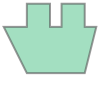

In [409]:
problems[2].room.polygon

In [410]:
len(problems[2].furniture)

120